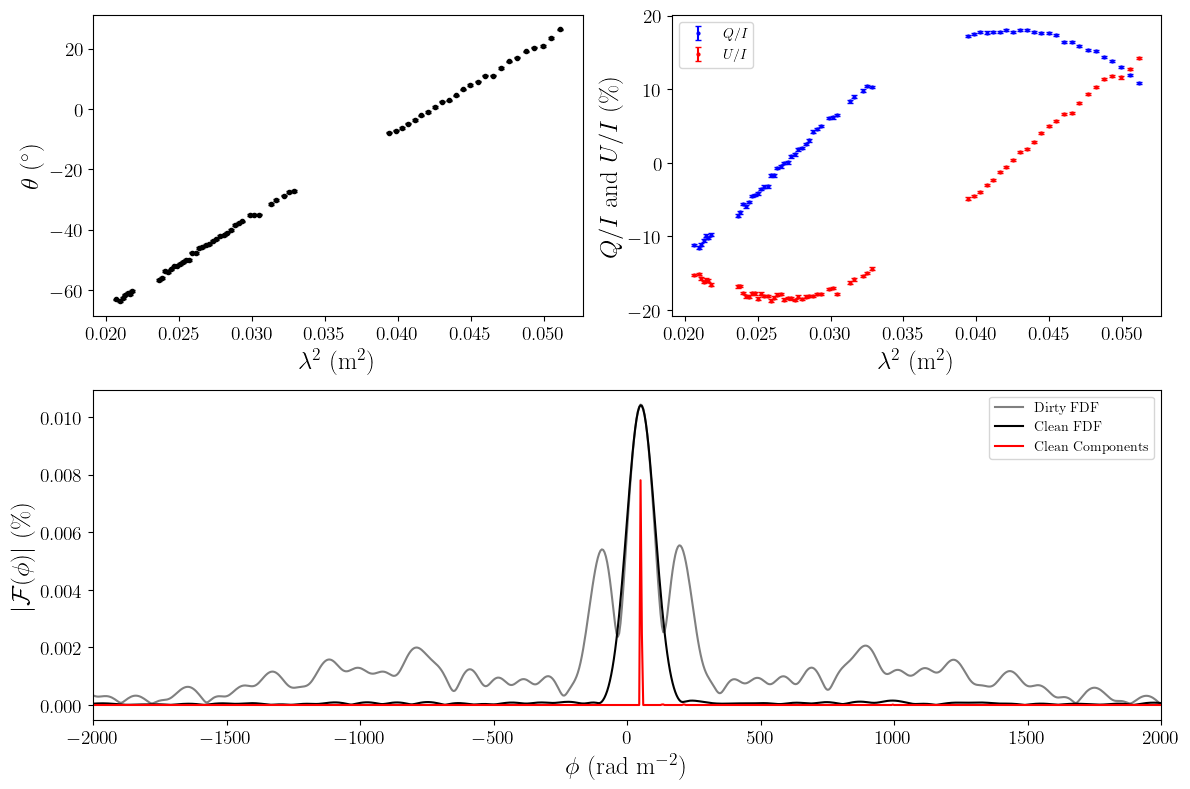

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from matplotlib import rc

# LaTeX and font settings
rc('font', family='serif')
rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

# Constants
c = 299792458.0  # speed of light in m/s

# Load files
profilename = '../paper2/32/RMsyn/H+52.159+30.836_4_4.dat'
FDFdirty_file = '../paper2/32/RMsyn/H+52.159+30.836_4_4_FDFdirty.dat'
FDFclean_file = '../paper2/32/RMsyn/H+52.159+30.836_4_4_FDFclean.dat'
FDFmodel_file = '../paper2/32/RMsyn/H+52.159+30.836_4_4_FDFmodel.dat'
RMTF_file = '../paper2/32/RMsyn/H+52.159+30.836_4_4_RMSF.dat'

# Load data
IQUpro = ascii.read(profilename)
FDF = ascii.read(FDFclean_file)
FDFmod = ascii.read(FDFmodel_file)
FDFdirty = ascii.read(FDFdirty_file)

# Extract data
freq = IQUpro['col1']
I = IQUpro['col2']
Q = IQUpro['col3']
U = IQUpro['col4']
dQ = IQUpro['col6']
dU = IQUpro['col7']

lambda_sq = (c / freq)**2

# Polarization fraction
QoverI = Q / I
UoverI = U / I
dQoverI = dQ / I
dUoverI = dU / I

# Polarization angle and error (in degrees)
theta_rad = 0.5 * np.unwrap(np.arctan2(U, Q))
theta_deg = np.degrees(theta_rad)
dtheta_deg = (1 / (1 + (U / Q)**2)) * np.sqrt((dU / Q)**2 + (U * dQ / Q**2)**2)
dtheta_deg = np.degrees(0.5 * dtheta_deg)

# FDF components
phi = FDF['col1']
F_Q = FDF['col2']
F_U = FDF['col3']
F_amp = np.sqrt(F_Q**2 + F_U**2)

phi_mod = FDFmod['col1']
F_mod_Q = FDFmod['col2']
F_mod_U = FDFmod['col3']
F_mod_amp = np.sqrt(F_mod_Q**2 + F_mod_U**2)

phi_dirty = FDFdirty['col1']
F_Q_dirty = FDFdirty['col2']
F_U_dirty = FDFdirty['col3']
F_amp_dirty = np.sqrt(F_Q_dirty**2 + F_U_dirty**2)

# Plot
fig = plt.figure(figsize=(12, 8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.1])
ax1 = plt.subplot(gs[0, 0])  # theta vs lambda^2
ax2 = plt.subplot(gs[0, 1])  # Q/I and U/I
ax3 = plt.subplot(gs[1, :])  # FDF plots

# θ(λ²)
ax1.errorbar(lambda_sq, theta_deg, yerr=dtheta_deg, fmt='k.', capsize=2)
# Optional fit: ax1.plot(lambda_sq, np.poly1d(np.polyfit(lambda_sq, theta_deg, 1))(lambda_sq), 'k-')
ax1.set_ylabel(r'$\theta\ (^\circ)$', fontsize=18)
ax1.set_xlabel(r'$\lambda^2\ (\mathrm{m}^2)$', fontsize=18)

# Q/I and U/I
ax2.errorbar(lambda_sq, 100 * QoverI, yerr=100 * dQoverI, fmt='o', color='blue', markersize=2, capsize=2, label=r'$Q/I$')
ax2.errorbar(lambda_sq, 100 * UoverI, yerr=100 * dUoverI, fmt='o', color='red', markersize=2, capsize=2, label=r'$U/I$')

ax2.set_xlabel(r'$\lambda^2\ (\mathrm{m}^2)$', fontsize=18)
ax2.set_ylabel(r'$Q/I\ \mathrm{and}\ U/I\ (\%)$', fontsize=18)
ax2.legend()

# Faraday depth spectrum
Iflux0 = 1e2
ax3.plot(phi_dirty, 100 * F_amp_dirty / Iflux0, color='gray', label='Dirty FDF')
ax3.plot(phi, 100 * F_amp / Iflux0, color='black', label='Clean FDF')
ax3.plot(phi_mod, 100 * F_mod_amp / Iflux0, color='red', label='Clean Components')
ax3.set_xlim(-2000, 2000)
ax3.set_xlabel(r'$\phi\ (\mathrm{rad}\ \mathrm{m}^{-2})$', fontsize=18)
ax3.set_ylabel(r'$|\mathcal{F}(\phi)|\ (\%)$', fontsize=18)
ax3.legend()

plt.tight_layout()
plt.savefig('../paper1/figs/RMresult.pdf')
plt.show()


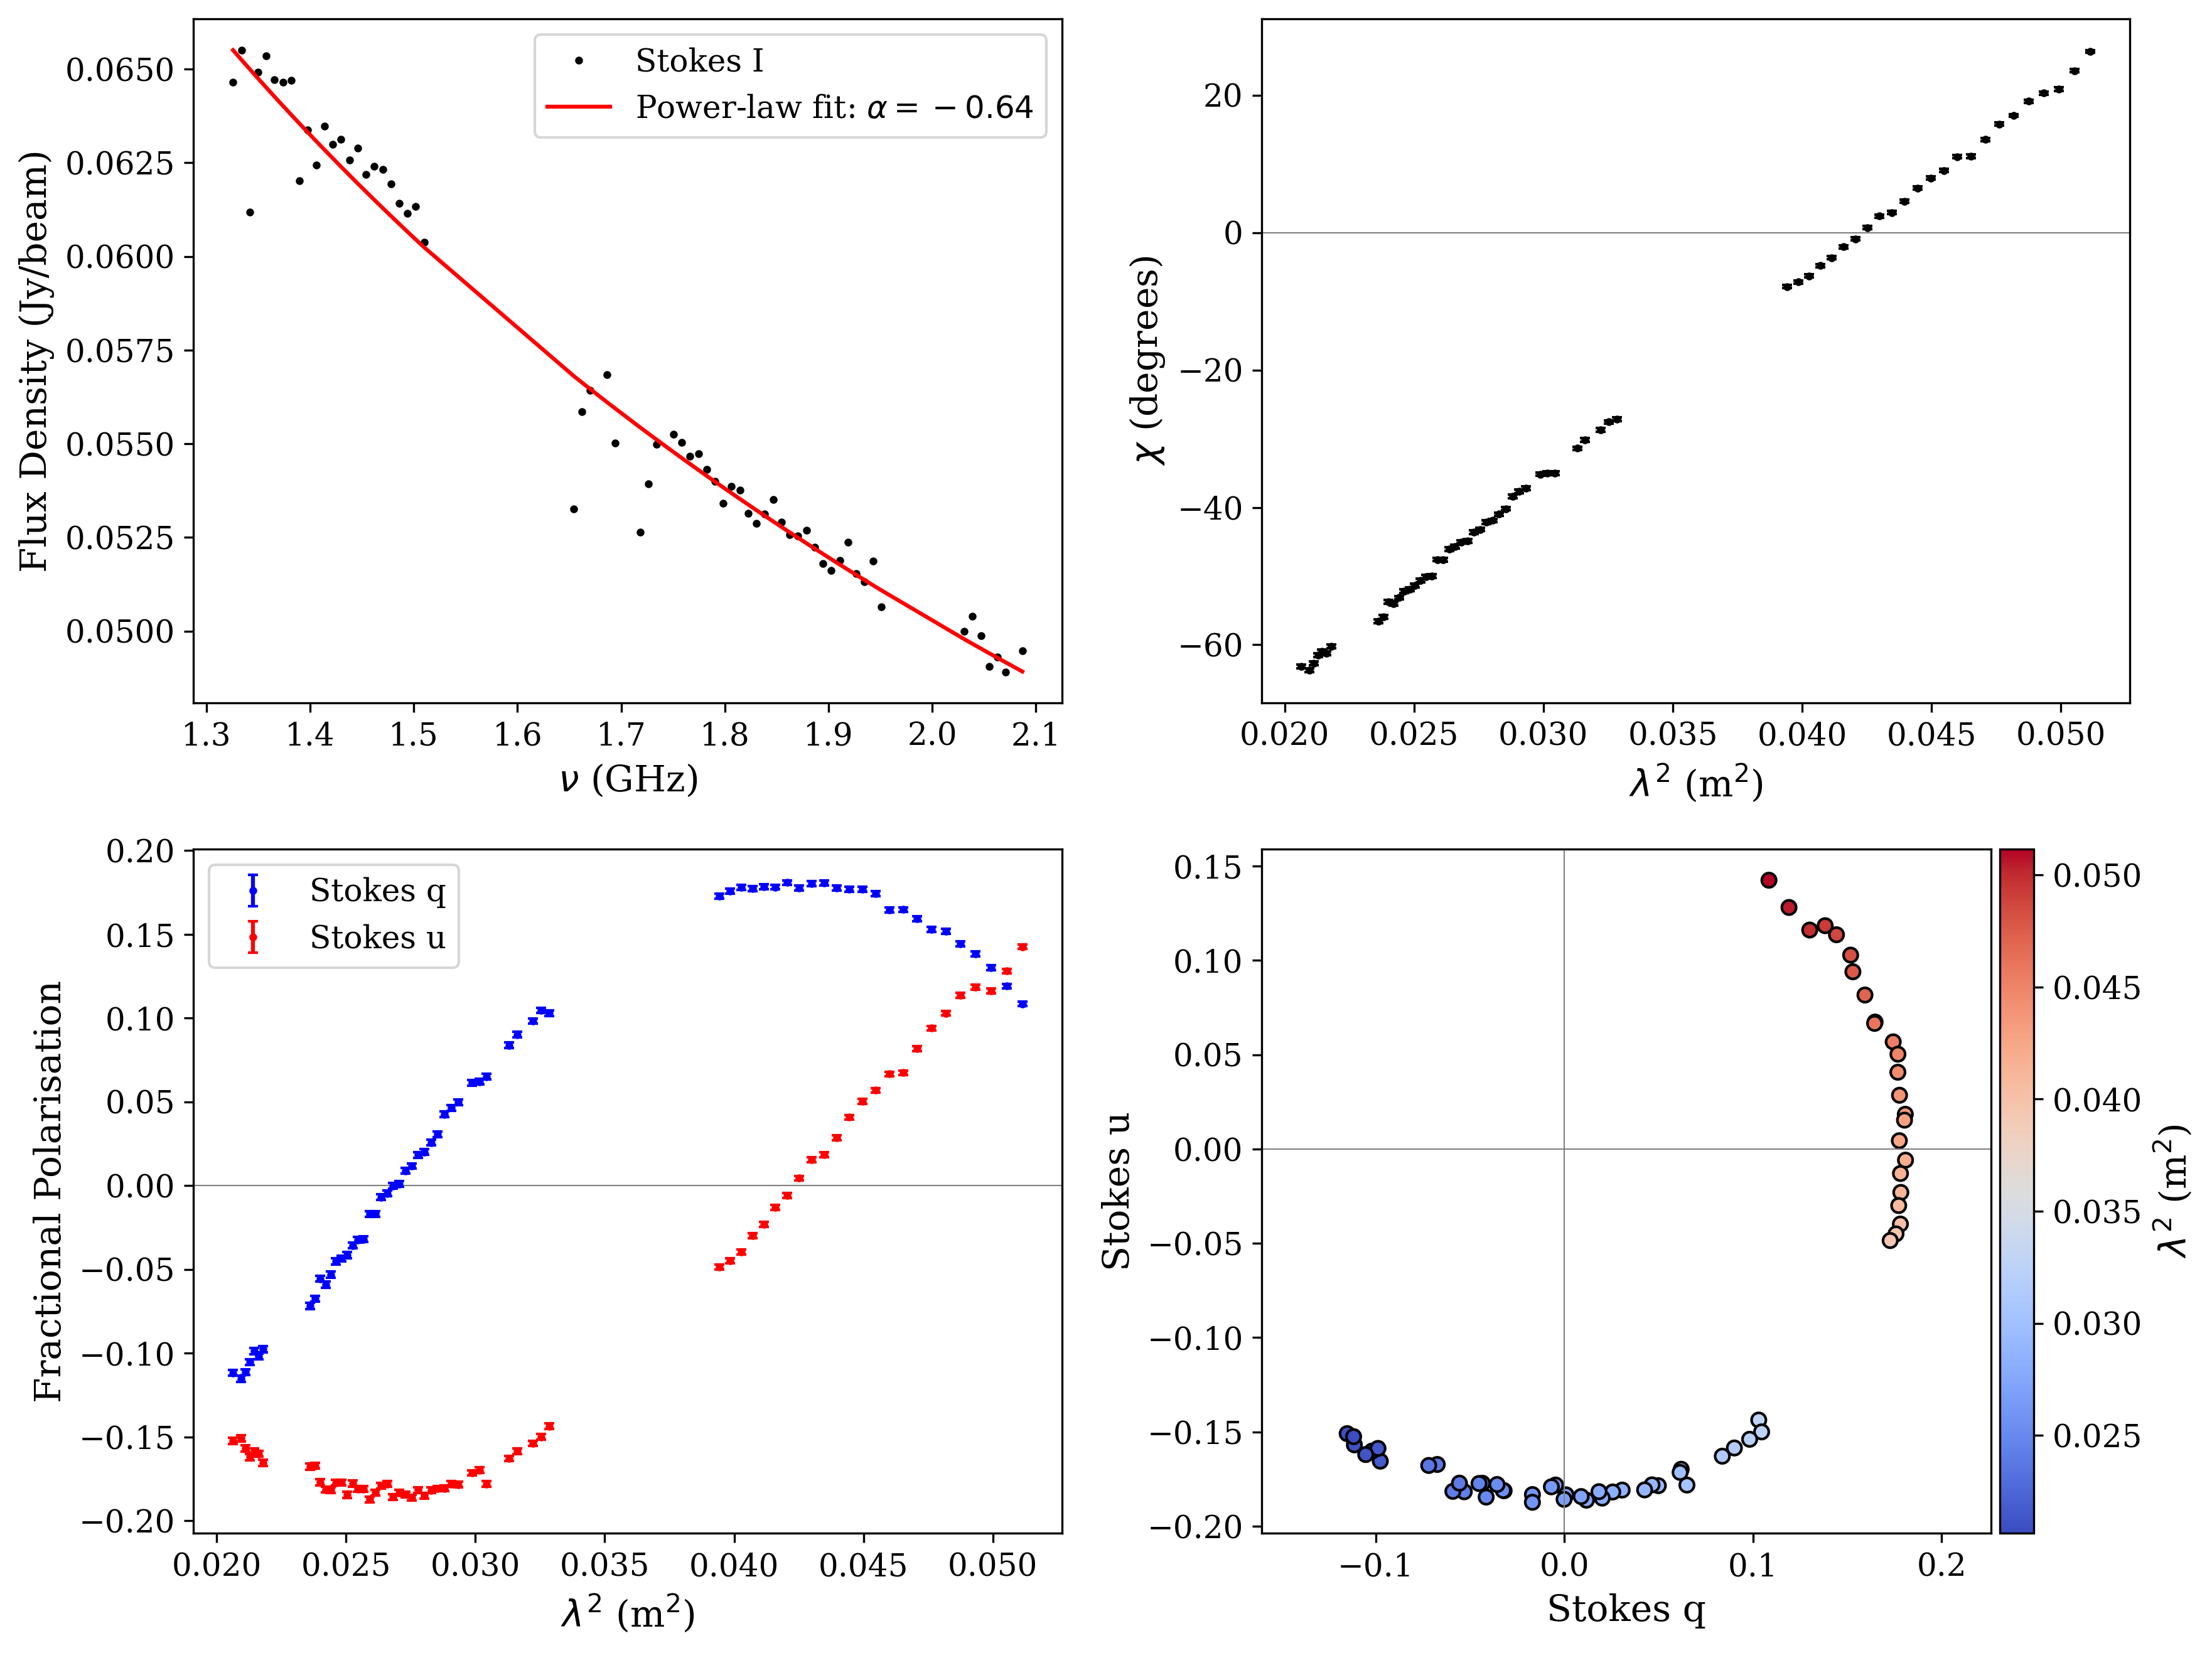

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from scipy.optimize import curve_fit

# === Plot Style Settings ===
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False
})

# === Constants ===
c = 299792458.0  # Speed of light in m/s

# === Load Data ===
profilename = '../paper2/32/RMsyn/H+52.159+30.836_4_4.dat'
IQUpro = ascii.read(profilename)

# === Extract Columns ===
freq = IQUpro['col1']      # Hz
I = IQUpro['col2']         # Jy/beam
Q = IQUpro['col3']
U = IQUpro['col4']
dQ = IQUpro['col6']
dU = IQUpro['col7']

lambda_sq = (c / freq)**2  # m^2

# === Polarization Fractions ===
q = Q / I
u = U / I
p = np.sqrt(q**2 + u**2)
dQoverI = dQ / I
dUoverI = dU / I

# === Polarization Angle and Uncertainty ===
theta_rad = 0.5 * np.unwrap(np.arctan2(U, Q))
theta_deg = np.degrees(theta_rad)
dtheta_deg = (1 / (1 + (U / Q)**2)) * np.sqrt((dU / Q)**2 + (U * dQ / Q**2)**2)
dtheta_deg = np.degrees(0.5 * dtheta_deg)

# === Power-law Fit for Stokes I ===
freq_ghz = freq / 1e9
nu0 = 1.5  # Reference frequency in GHz

def power_law(nu, I0, alpha):
    return I0 * (nu / nu0)**alpha

popt, pcov = curve_fit(power_law, freq_ghz, I, p0=(np.median(I), -0.8))
I0_fit, alpha_fit = popt
fit_line = power_law(freq_ghz, *popt)

# === Fit Sinusoids to q and u ===
def q_model(l2, A, phi, psi):
    return A * np.cos(2 * phi * l2 + psi)

def u_model(l2, A, phi, psi):
    return A * np.sin(2 * phi * l2 + psi)

# Initial guess: A, phi, psi
guess = (np.max(q), 50, 0)
popt_q, _ = curve_fit(q_model, lambda_sq, q, p0=guess)
popt_u, _ = curve_fit(u_model, lambda_sq, u, p0=guess)

l2_fine = np.linspace(min(lambda_sq), max(lambda_sq), 500)
q_fit = q_model(l2_fine, *popt_q)
u_fit = u_model(l2_fine, *popt_u)

# === Plot ===
fig, axs = plt.subplots(2, 2, figsize=(12, 9))
(ax1, ax2), (ax3, ax4) = axs

# 1. Stokes I vs Frequency (Power-law)
ax1.plot(freq_ghz, I, 'k.', markersize=4, label='Stokes I')
ax1.plot(freq_ghz, fit_line, 'r-', label=rf'Power-law fit: $\alpha = {alpha_fit:.2f}$')
ax1.set_xlabel(r'$\nu$ (GHz)')
ax1.set_ylabel(r'Flux Density (Jy/beam)')
ax1.legend()

# 2. Polarization angle vs lambda^2
ax2.errorbar(lambda_sq, theta_deg, yerr=dtheta_deg, markersize=4, fmt='k.', capsize=2)
ax2.set_xlabel(r'$\lambda^2$ (m$^2$)')
ax2.set_ylabel(r'$\chi$ (degrees)')
ax2.axhline(0, color='gray', lw=0.5)

# 3. Fractional polarization vs lambda^2 with sinusoidal fits
ax3.errorbar(lambda_sq, q, yerr=dQoverI, fmt='o', color='blue', markersize=2, capsize=2, label='Stokes q')
ax3.errorbar(lambda_sq, u, yerr=dUoverI, fmt='o', color='red', markersize=2, capsize=2, label='Stokes u')
# ax3.plot(l2_fine, q_fit, color='blue', linestyle='--', label='Fit q')
# ax3.plot(l2_fine, u_fit, color='red', linestyle='--', label='Fit u')
ax3.set_xlabel(r'$\lambda^2$ (m$^2$)')
ax3.set_ylabel(r'Fractional Polarisation')
ax3.axhline(0, color='gray', lw=0.5)
ax3.legend()

# 4. Q-U plane with colorbar for lambda^2
sc = ax4.scatter(q, u, c=lambda_sq, cmap='coolwarm', s=30, edgecolor='k')
ax4.axhline(0, color='gray', lw=0.5)
ax4.axvline(0, color='gray', lw=0.5)
ax4.set_xlabel('Stokes q')
ax4.set_ylabel('Stokes u')
ax4.set_aspect('equal', adjustable='datalim')


# Colorbar
cbar = fig.colorbar(sc, ax=ax4, orientation='vertical', pad=0.01)
cbar.set_label(r'$\lambda^2$ (m$^2$)', fontsize=14)

# Layout and Save
plt.tight_layout()
plt.savefig('../paper1/figs/spectra_qu_theta_flux.pdf')
plt.show()


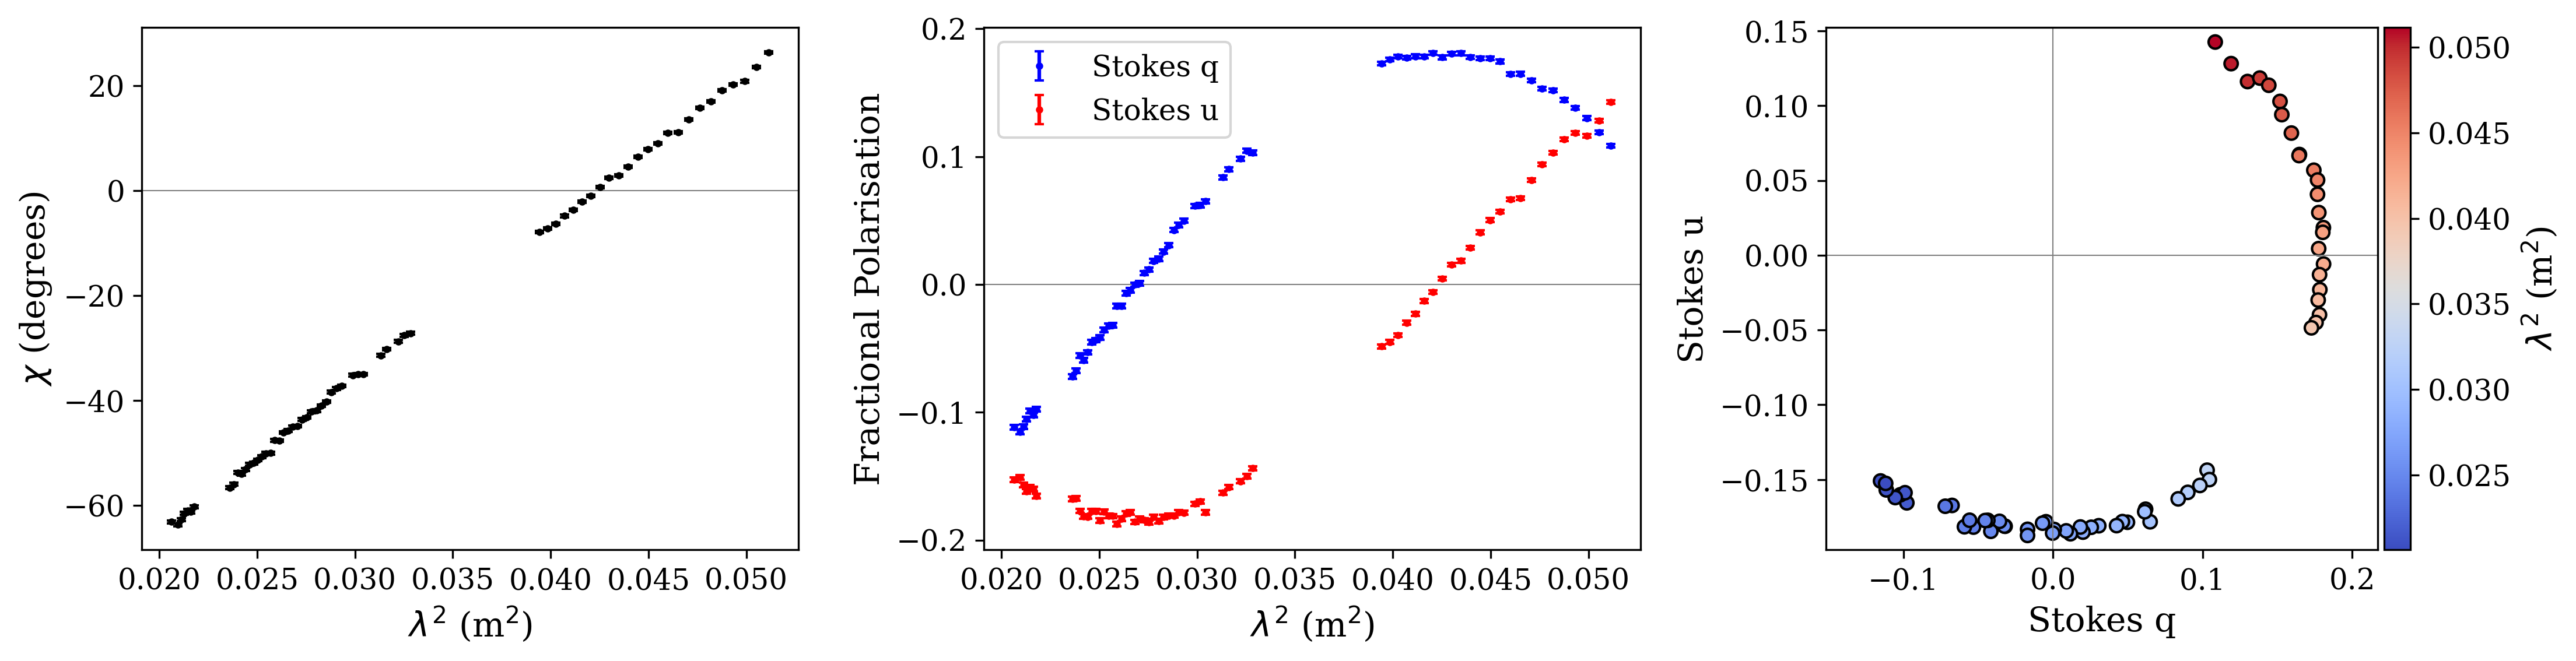

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from scipy.optimize import curve_fit

# === Plot Style Settings ===
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False
})

# === Constants ===
c = 299792458.0  # Speed of light in m/s

# === Load Data ===
profilename = '../paper2/32/RMsyn/H+52.159+30.836_4_4.dat'
IQUpro = ascii.read(profilename)

# === Extract Columns ===
freq = IQUpro['col1']      # Hz
I = IQUpro['col2']         # Jy/beam
Q = IQUpro['col3']
U = IQUpro['col4']
dQ = IQUpro['col6']
dU = IQUpro['col7']

lambda_sq = (c / freq)**2  # m^2

# === Polarization Fractions ===
q = Q / I
u = U / I
p = np.sqrt(q**2 + u**2)
dQoverI = dQ / I
dUoverI = dU / I

# === Polarization Angle and Uncertainty ===
theta_rad = 0.5 * np.unwrap(np.arctan2(U, Q))
theta_deg = np.degrees(theta_rad)
dtheta_deg = (1 / (1 + (U / Q)**2)) * np.sqrt((dU / Q)**2 + (U * dQ / Q**2)**2)
dtheta_deg = np.degrees(0.5 * dtheta_deg)

# === Power-law Fit for Stokes I ===
freq_ghz = freq / 1e9
nu0 = 1.5  # Reference frequency in GHz

def power_law(nu, I0, alpha):
    return I0 * (nu / nu0)**alpha

popt, pcov = curve_fit(power_law, freq_ghz, I, p0=(np.median(I), -0.8))
I0_fit, alpha_fit = popt
fit_line = power_law(freq_ghz, *popt)

# === Fit Sinusoids to q and u ===
def q_model(l2, A, phi, psi):
    return A * np.cos(2 * phi * l2 + psi)

def u_model(l2, A, phi, psi):
    return A * np.sin(2 * phi * l2 + psi)

# Initial guess: A, phi, psi
guess = (np.max(q), 50, 0)
popt_q, _ = curve_fit(q_model, lambda_sq, q, p0=guess)
popt_u, _ = curve_fit(u_model, lambda_sq, u, p0=guess)

l2_fine = np.linspace(min(lambda_sq), max(lambda_sq), 500)
q_fit = q_model(l2_fine, *popt_q)
u_fit = u_model(l2_fine, *popt_u)

# === Plot ===
# === Plot ===
fig, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(15, 4))

# 1. Polarization angle vs lambda^2
ax2.errorbar(lambda_sq, theta_deg, yerr=dtheta_deg,
             markersize=4, fmt='k.', capsize=2)
ax2.set_xlabel(r'$\lambda^2$ (m$^2$)')
ax2.set_ylabel(r'$\chi$ (degrees)')
ax2.axhline(0, color='gray', lw=0.5)

# 2. Fractional polarization vs lambda^2 with sinusoidal fits
ax3.errorbar(lambda_sq, q, yerr=dQoverI, fmt='o', color='blue',
             markersize=2, capsize=2, label='Stokes q')
ax3.errorbar(lambda_sq, u, yerr=dUoverI, fmt='o', color='red',
             markersize=2, capsize=2, label='Stokes u')
# ax3.plot(l2_fine, q_fit, color='blue', linestyle='--', label='Fit q')
# ax3.plot(l2_fine, u_fit, color='red', linestyle='--', label='Fit u')
ax3.set_xlabel(r'$\lambda^2$ (m$^2$)')
ax3.set_ylabel(r'Fractional Polarisation')
ax3.axhline(0, color='gray', lw=0.5)
ax3.legend()

# 3. Q-U plane with colorbar for lambda^2
sc = ax4.scatter(q, u, c=lambda_sq, cmap='coolwarm', s=30, edgecolor='k')
ax4.axhline(0, color='gray', lw=0.5)
ax4.axvline(0, color='gray', lw=0.5)
ax4.set_xlabel('Stokes q')
ax4.set_ylabel('Stokes u')
ax4.set_aspect('equal', adjustable='datalim')

# Colorbar (attached to the Q–U panel)
cbar = fig.colorbar(sc, ax=ax4, orientation='vertical', pad=0.01)
cbar.set_label(r'$\lambda^2$ (m$^2$)', fontsize=14)

# Layout and Save
plt.tight_layout()
plt.savefig('../paper1/figs/spectra_qu_theta_flux.pdf')
plt.show()


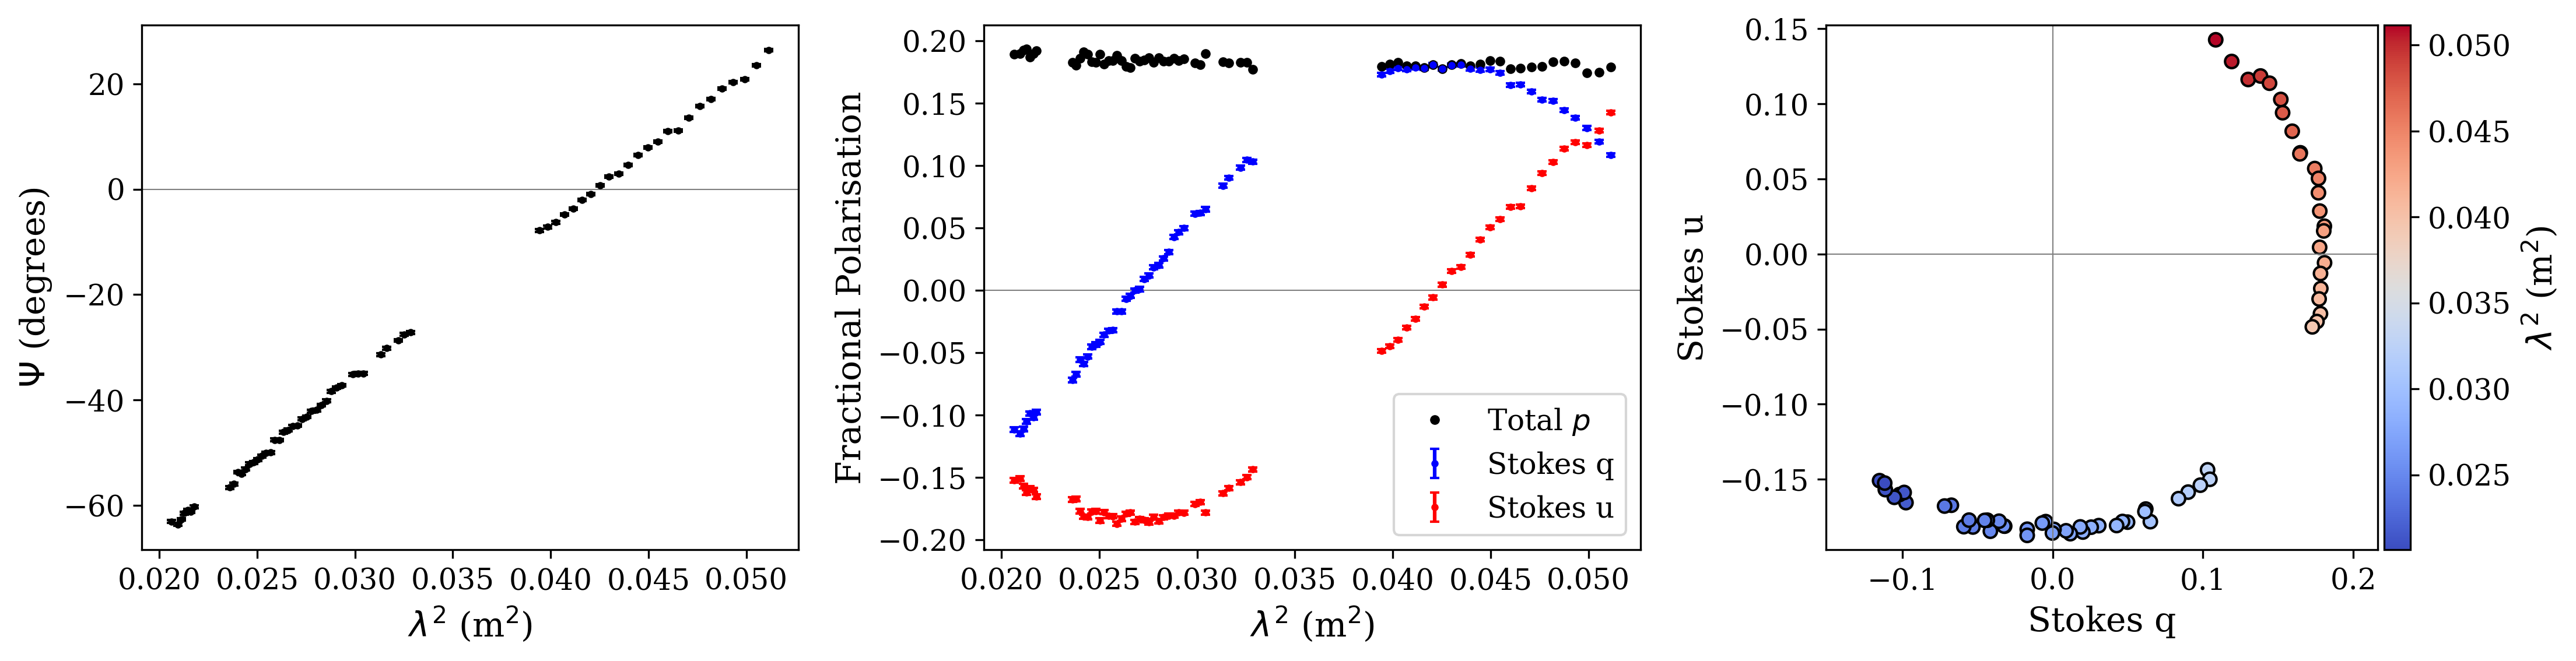

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from scipy.optimize import curve_fit

# === Plot Style Settings ===
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False
})

# === Constants ===
c = 299792458.0  # Speed of light in m/s

# === Load Data ===
profilename = '../paper2/32/RMsyn/H+52.159+30.836_4_4.dat'
IQUpro = ascii.read(profilename)

# === Extract Columns ===
freq = IQUpro['col1']      # Hz
I = IQUpro['col2']         # Jy/beam
Q = IQUpro['col3']
U = IQUpro['col4']
dQ = IQUpro['col6']
dU = IQUpro['col7']

lambda_sq = (c / freq)**2  # m^2

# === Polarization Fractions ===
q = Q / I
u = U / I
p_total = np.sqrt(Q**2 + U**2) / I
dQoverI = dQ / I
dUoverI = dU / I

# === Polarization Angle and Uncertainty ===
theta_rad = 0.5 * np.unwrap(np.arctan2(U, Q))
theta_deg = np.degrees(theta_rad)
dtheta_deg = (1 / (1 + (U / Q)**2)) * np.sqrt((dU / Q)**2 + (U * dQ / Q**2)**2)
dtheta_deg = np.degrees(0.5 * dtheta_deg)

# === Power-law Fit for Stokes I (still computed, just not plotted) ===
freq_ghz = freq / 1e9
nu0 = 1.5  # Reference frequency in GHz

def power_law(nu, I0, alpha):
    return I0 * (nu / nu0)**alpha

popt, pcov = curve_fit(power_law, freq_ghz, I, p0=(np.median(I), -0.8))
I0_fit, alpha_fit = popt
fit_line = power_law(freq_ghz, *popt)

# === Fit Sinusoids to q and u ===
def q_model(l2, A, phi, psi):
    return A * np.cos(2 * phi * l2 + psi)

def u_model(l2, A, phi, psi):
    return A * np.sin(2 * phi * l2 + psi)

guess = (np.max(q), 50, 0)
popt_q, _ = curve_fit(q_model, lambda_sq, q, p0=guess)
popt_u, _ = curve_fit(u_model, lambda_sq, u, p0=guess)

# === Plot: 1x3 (Stokes I panel removed) ===
fig, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(15, 4))

# 1. Polarization angle vs lambda^2
ax2.errorbar(lambda_sq, theta_deg, yerr=dtheta_deg,
             markersize=4, fmt='k.', capsize=2)
ax2.set_xlabel(r'$\lambda^2$ (m$^2$)')
ax2.set_ylabel(r'$\Psi$ (degrees)')
ax2.axhline(0, color='gray', lw=0.5)

# 2. q, u, and p_total vs lambda^2
ax3.errorbar(lambda_sq, q, yerr=dQoverI, fmt='o',
             color='blue', markersize=2, capsize=2, label='Stokes q')
ax3.errorbar(lambda_sq, u, yerr=dUoverI, fmt='o',
             color='red', markersize=2, capsize=2, label='Stokes u')
ax3.plot(lambda_sq, p_total, 'ko', markersize=3, label=r'Total $p$')

ax3.set_xlabel(r'$\lambda^2$ (m$^2$)')
ax3.set_ylabel(r'Fractional Polarisation')
ax3.axhline(0, color='gray', lw=0.5)
ax3.legend()

# 3. Q–U plane
sc = ax4.scatter(q, u, c=lambda_sq, cmap='coolwarm',
                 s=30, edgecolor='k')
ax4.axhline(0, color='gray', lw=0.5)
ax4.axvline(0, color='gray', lw=0.5)
ax4.set_xlabel('Stokes q')
ax4.set_ylabel('Stokes u')
ax4.set_aspect('equal', adjustable='datalim')

# Colorbar
cbar = fig.colorbar(sc, ax=ax4, orientation='vertical', pad=0.01)
cbar.set_label(r'$\lambda^2$ (m$^2$)', fontsize=14)

# Layout and Save
plt.tight_layout()
plt.savefig('../paper1/figs/spectra_qu_theta_flux.pdf')
plt.show()


# RM Clean

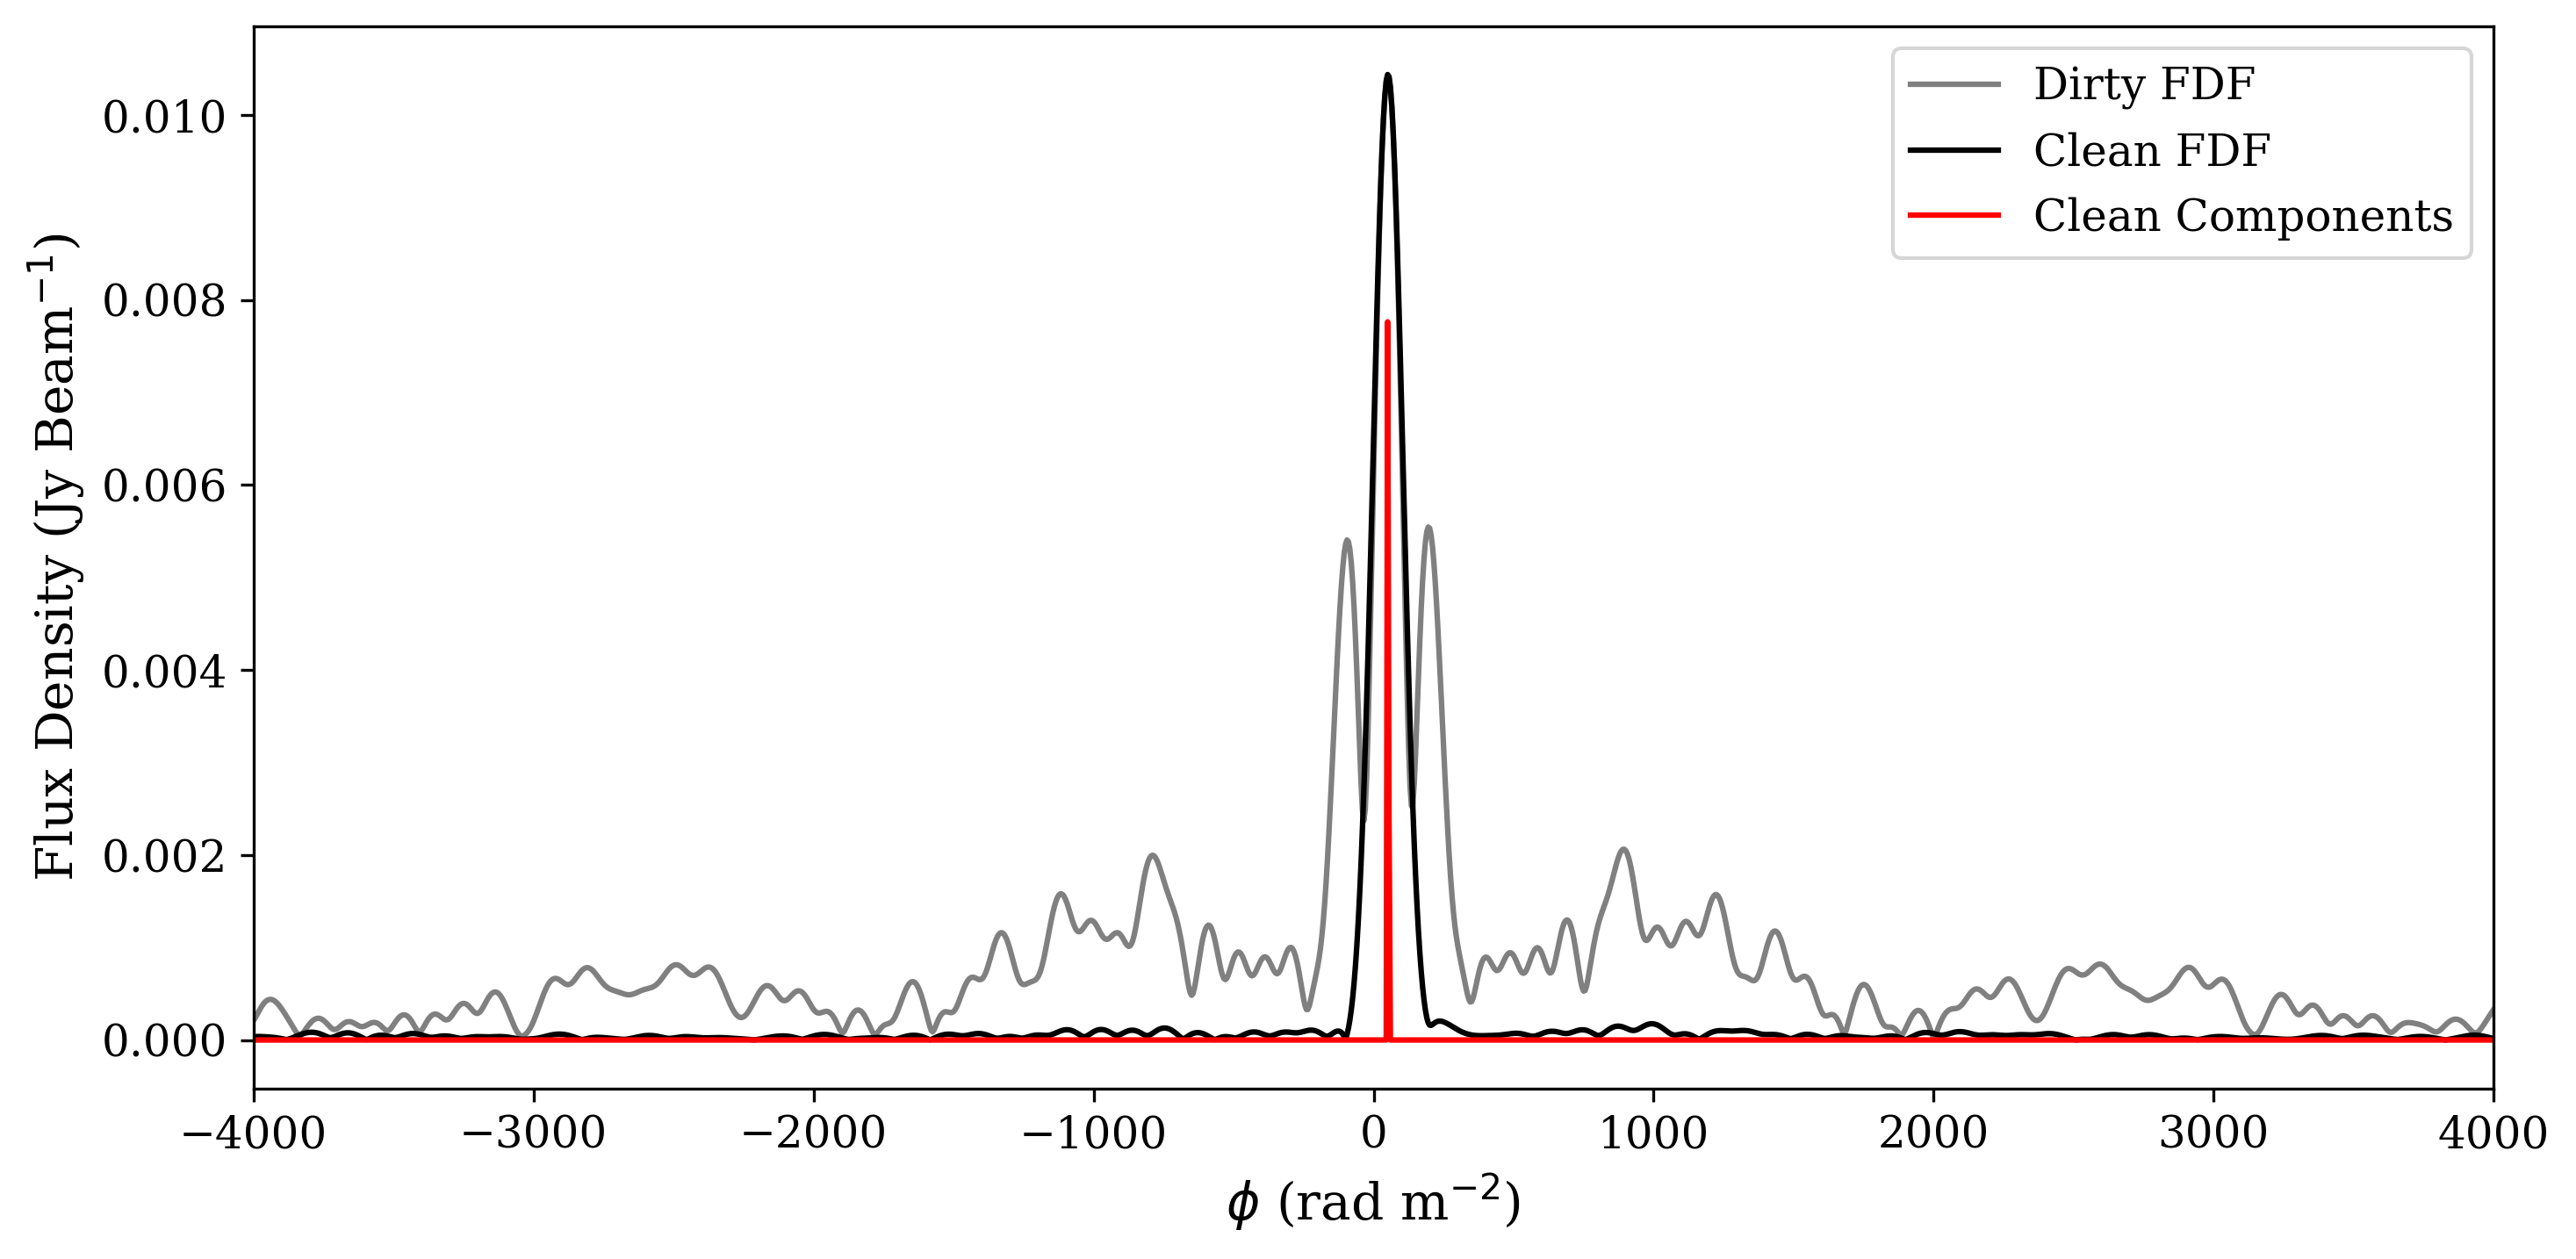

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii

# === Plot style settings ===
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.usetex': False
})

# === Load data ===
fdf_dirty = ascii.read('../paper2/32/RMsyn/H+52.159+30.836_4_4_FDFdirty.dat')
fdf_clean = ascii.read('../paper2/32/RMsyn/H+52.159+30.836_4_4_FDFclean.dat')
fdf_model = ascii.read('../paper2/32/RMsyn/H+52.159+30.836_4_4_FDFmodel.dat')

# === Extract amplitudes ===
phi_dirty = fdf_dirty['col1']
P_dirty = np.sqrt(fdf_dirty['col2']**2 + fdf_dirty['col3']**2)

phi_clean = fdf_clean['col1']
P_clean = np.sqrt(fdf_clean['col2']**2 + fdf_clean['col3']**2)

phi_model = fdf_model['col1']
P_model = np.sqrt(fdf_model['col2']**2 + fdf_model['col3']**2)

# === Clean cutoff threshold ===
cutoff = 0.001  # Jy/beam

# === Plot ===
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(phi_dirty, P_dirty, color='gray', label='Dirty FDF')
ax.plot(phi_clean, P_clean, color='black', label='Clean FDF')
ax.plot(phi_model, P_model, color='red', label='Clean Components')
# ax.axhline(y=cutoff, color='green', linestyle=':', label='Clean cutoff')

ax.set_xlabel(r'$\phi$ (rad m$^{-2}$)')
ax.set_ylabel('Flux Density (Jy Beam$^{-1}$)')
ax.legend(loc='upper right')
ax.set_xlim(-4000, 4000)

plt.tight_layout()
plt.savefig('../paper1/figs/cleanFDF_singlepanel.pdf')
plt.show()


# P = np.sqrt(Q**2+U**2)

In [6]:
import numpy as np
from astropy.io import fits
import os

# ===============================
# Datasets to process
# ===============================
datasets = [23, 25, 32, 36]

base_dir = "../server/total"

for ds in datasets:
    q_file = f"{base_dir}/{ds}Q.fits"
    u_file = f"{base_dir}/{ds}U.fits"
    p_file = f"{base_dir}/{ds}P.fits"

    print(f"Processing dataset {ds}...")

    # --- Read Q ---
    with fits.open(q_file) as hdu_q:
        Q = hdu_q[0].data.astype(float)
        header = hdu_q[0].header

    # --- Read U ---
    with fits.open(u_file) as hdu_u:
        U = hdu_u[0].data.astype(float)

    # --- Compute polarized intensity ---
    P = np.sqrt(Q**2 + U**2)

    # --- Write output FITS ---
    hdu_p = fits.PrimaryHDU(data=P, header=header)
    hdu_p.writeto(p_file, overwrite=True)

    print(f"  → Saved {p_file}")

print("✅ All datasets processed.")


Processing dataset 23...
  → Saved ../server/total/23P.fits
Processing dataset 25...
  → Saved ../server/total/25P.fits
Processing dataset 32...
  → Saved ../server/total/32P.fits
Processing dataset 36...
  → Saved ../server/total/36P.fits
✅ All datasets processed.
